This will be my GAN model used to create semi-realistic face images using the celeb A dataset.  First I will import all of the relevant libraries 

In [28]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision import datasets

Next I will create a seed for this torch model in order to have reproducibility for the model.  We will also use deterministic algorithms to true as well to again ensure reproducibility of the results. 

In [29]:
manualSeed = 999 # Random choice for reproducing same results
print("Random Seed: ", manualSeed) # Print out the seed 
random.seed(manualSeed) # Set the seed 
torch.manual_seed(manualSeed) # Set the seed in pytorch
torch.use_deterministic_algorithms(True) # Turn on the deterministic algorithms 

Random Seed:  999


Next we will setup the hyperparameters for the model.  These include the dataset directory path, the number of workers for the dataloader, the batch size for training, the size of the images.  We also set the number of input channels for the model (3 for colour images), the latent vector size for the generator input, the feature map sizes for the generator and the discriminator.  The number of epochs or training cycles, the learning rate of the model, the Beta1 paramentere for the Adam optimiser and the number of available GPU's 

In [30]:
dataroot = './CelebA' # Root directory for dataset
workers = 2 # Number of workers for dataloader
batch_size = 128 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this. #   size using a transformer.
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 5 # Number of training epochs, arbitrary choice mainly for time 
lr = 0.0002 # Learning rate for optimizers, we want to avoid overshooting 
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers
ngpu = 1 # Number of GPUs available. Use 0 for CPU mode.

Next we will want to load in our data for the celebA dataset.  I will have it downloaded locally in my the same directoty as my model. in the CelebA directory it has the following structure. 

./CelebA
    -> ./img_align_celeba
    -> identity_CelebA.txt
    -> list_attr_celeba.txt
    -> list_bbox_celeba.txt
    -> list_eval_partition.txt
    -> list_landmarks_align.txt
    -> list_landmarks_celeba.txt

Then we load this data into an ImageFolder dset, apply our transforms and then load the new dataset into the dataloader we will use for the model 

In [31]:
# Use an image folder to store the local data and load it in 
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# The transform to apply to the data for better overall results
transform=transforms.Compose([transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

Now we will setup the gpu, as the device to use for the model, using the parrelism of the GPU will be vital for this model due to how much processing that we need to do. 

In [32]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")# Decide which device we want to run on

Now lets print out some pretty images to look at 

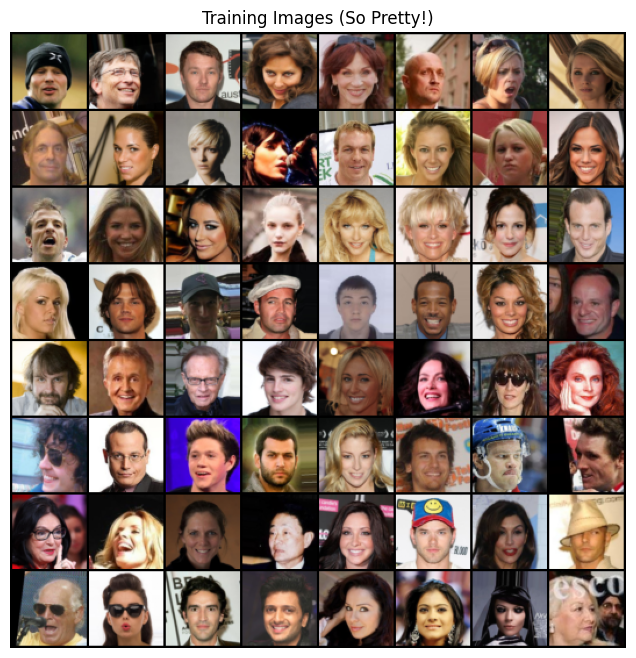

In [33]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images (So Pretty!)")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Next we wanna set the weights for the models to use that is both the netG and netD (Generator and Discriminator Neural Networks).  

In [34]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Now we get to the fun part its time to create the models for the generator and the discriminator neural networks.  We will create the generator model first. 

This Generator network takes a random noise vector 'Z' as input and transforms it through a series of transposed convolutional layers with batch normalization and ReLU activations to produce a synthetic image that aims to resemble real data samples. The architecture gradually increases the spatial resolution while adjusting the number of features, ultimately generating an image of size 3 x 64 x 64. 

Now lets break down each of the functions used in the layers of this model:

ConvTranspose2d -> This is a transposed convolution layer, it increases spatial resolution of the image data aka unsampling.

BatchNorm2d -> This applies a batch normalisation to the output of the convolutional layer, its used to stabilsie the training by normalising the inputs

ReLU -> Thus is an activation function that takes the output and introduces non-linearity. 

Tanh -> This is an activation function that takes the input and compressess it between -1 and 1 which is a sutiable range for generating pixel values. 

In [35]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

Next we will create the generator model, applying the inital weights that we wanted with mean 0 and stdev of 0.02.  So that the weights start with random values.  In the hopes to make the model slightly faster compared to uninitialised weights. 

In [36]:
netG = Generator(ngpu).to(device) # Create the generator
netG.apply(weights_init) # Apply the ``weights_init`` function to randomly initialize all weights
print(netG) # Print the model

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


Now lets to the same thing with the Discriminator model, It will obviouslty be using different layers for it's model so we will do through them below:

Conv2d -> Performs a convolutional operations used to detect the complex facial patterns we are analysing.  Its how we are actually trying to classify the faces

BatchNorm2d ->  This applies a batch normalisation to the output of the convolutional layer, its used to stabilsie the training by normalising the inputs.

LeakyRelu -> This is an activation function that is used instead of a normal Relu due to the dying relu problem where neurons become inactive during training, it allows for negative outputs to be processed better and continue to flow through the network therefore making the network easier to train. 

Sigmoid -> Activation function that squashes the output values between 0 and 1 which is ideal for out last layer as we want to decide the probability of the image being real or fake. 


In [37]:

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Now lets do the same thing and create the discriminator model and set its weights.  Then we will print it out to the screen 

In [38]:
netD = Discriminator(ngpu).to(device) # Create the Discriminator
netD.apply(weights_init) # Apply the ``weights_init`` function to randomly initialize all weights
print(netD) # Print the model

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Now lets setup the loss and optimiser functions as well as some noise vectors and images labels before we get into the meat of training. Below is a breakdown of the Adam optimiser and the BCE loss function:

Adam Optimizer -> This is a optimiser used to update the weights of the layers to make the network more accurate through back propogation.  It dynamically adjusts the learning rates for each parameter therefore reducing the need for a learning rate scheduler.  

BCE Loss -> Binary Cross Entropy Loss, is a loss function designed to calculating the loss when ther are two possible outcomes, in our case these are fake or real. So it is the most suited for our classsification

In [39]:
criterion = nn.BCELoss() # Initialize the ``BCELoss`` function
fixed_noise = torch.randn(64, nz, 1, 1, device=device) # Create batch of latent vectors that we will use to visualize the progression of the generator
real_label = 1. # Real labels will be represented with a 1
fake_label = 0. # Fake labels will be a 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # Setup Adam optimizer for the Discriminator
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) # Setup Adam optimizer for the Generator

Now its time to begin training our model.  

In [40]:
# Lists to keep track of progress
img_list = []  # List to store generated images for visualization
G_losses = []  # List to store Generator losses
D_losses = []  # List to store Discriminator losses
iters = 0  # Counter for iterations

# Training Loop
print("Starting Training Loop...")
for epoch in range(num_epochs):  # Loop over the number of training epochs
    for i, data in enumerate(dataloader, 0):  # Loop over each batch in the dataloader

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Train with real data
        netD.zero_grad()  # Zero the gradients in the Discriminator
        real_cpu = data[0].to(device)  # Get a batch of real data
        b_size = real_cpu.size(0)  # Get the batch size
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)  # Create labels for real data
        output = netD(real_cpu).view(-1)  # Forward pass real data through D
        errD_real = criterion(output, label)  # Calculate loss on real data
        errD_real.backward()  # Backpropagate and compute gradients for D
        D_x = output.mean().item()  # Calculate the mean of D's output (real data)

        # Train with fake data
        noise = torch.randn(b_size, nz, 1, 1, device=device)  # Generate random noise vectors
        fake = netG(noise)  # Generate fake images using the Generator
        label.fill_(fake_label)  # Create labels for fake data
        output = netD(fake.detach()).view(-1)  # Forward pass fake data through D
        errD_fake = criterion(output, label)  # Calculate loss on fake data
        errD_fake.backward()  # Backpropagate and compute gradients for D (accumulated with previous gradients)
        D_G_z1 = output.mean().item()  # Calculate the mean of D's output (fake data)
        errD = errD_real + errD_fake  # Combine losses from real and fake data
        optimizerD.step()  # Update Discriminator's weights

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()  # Zero the gradients in the Generator
        label.fill_(real_label)  # Fake labels are treated as real for Generator cost
        output = netD(fake).view(-1)  # Forward pass fake data (generated by G) through D
        errG = criterion(output, label)  # Calculate Generator's loss
        errG.backward()  # Backpropagate and compute gradients for G
        D_G_z2 = output.mean().item()  # Calculate the mean of D's output for fake data
        optimizerG.step()  # Update Generator's weights

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch + 1, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()  # Generate fake images from fixed noise
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))  # Store generated images

        iters += 1  # Increment the iteration counter


Starting Training Loop...
[1/5][0/1583]	Loss_D: 1.7302	Loss_G: 5.7032	D(x): 0.5830	D(G(z)): 0.5920 / 0.0057
[1/5][50/1583]	Loss_D: 0.5273	Loss_G: 18.1650	D(x): 0.9952	D(G(z)): 0.3237 / 0.0000
[1/5][100/1583]	Loss_D: 0.2793	Loss_G: 7.8119	D(x): 0.9004	D(G(z)): 0.0852 / 0.0010
[1/5][150/1583]	Loss_D: 0.5289	Loss_G: 5.5796	D(x): 0.9463	D(G(z)): 0.3184 / 0.0093
[1/5][200/1583]	Loss_D: 0.8823	Loss_G: 5.3425	D(x): 0.5446	D(G(z)): 0.0054 / 0.0107
[1/5][250/1583]	Loss_D: 0.4016	Loss_G: 3.0656	D(x): 0.8414	D(G(z)): 0.1214 / 0.0787
[1/5][300/1583]	Loss_D: 0.5930	Loss_G: 2.4285	D(x): 0.7031	D(G(z)): 0.1129 / 0.1168
[1/5][350/1583]	Loss_D: 0.5777	Loss_G: 3.0255	D(x): 0.7256	D(G(z)): 0.1219 / 0.0815
[1/5][400/1583]	Loss_D: 0.4107	Loss_G: 3.4435	D(x): 0.8289	D(G(z)): 0.1414 / 0.0490
[1/5][450/1583]	Loss_D: 0.8081	Loss_G: 7.3541	D(x): 0.9183	D(G(z)): 0.4066 / 0.0027
[1/5][500/1583]	Loss_D: 0.7637	Loss_G: 6.4971	D(x): 0.8667	D(G(z)): 0.3650 / 0.0037
[1/5][550/1583]	Loss_D: 0.3129	Loss_G: 6.0558	D(x): 

Now that our training is complete, lets create a plot of the overall loss of the generator and the discrimator throughout the training cycle, in order to see how they improved over time.

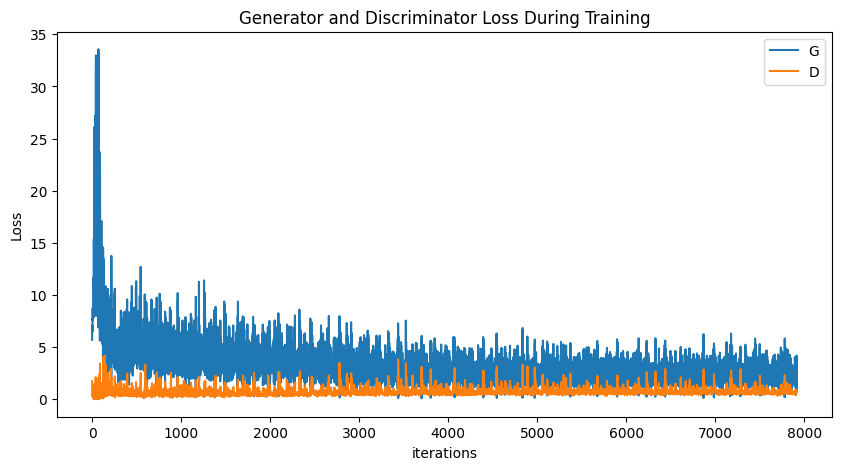

In [41]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Now lets compare some real images to the images that our generator has created during the training cycle to get a gauge as to how well we have done in training.   

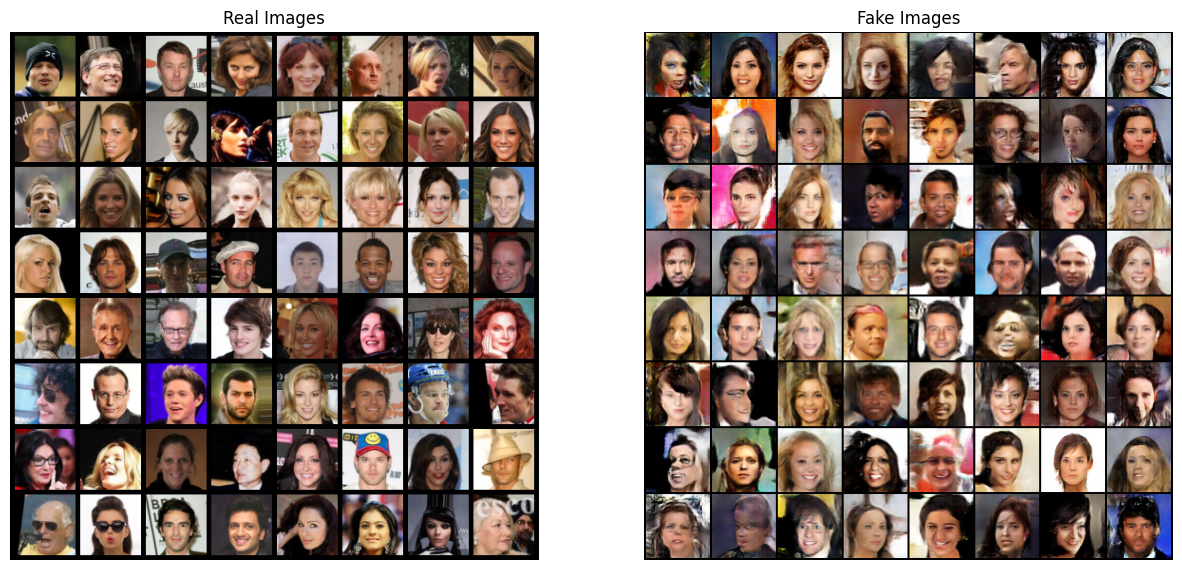

In [42]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()